In [1]:
using Flux, Distributions, Plots, StatsPlots, Zygote, ForwardDiff, LinearAlgebra, Random

In [2]:
#Durbin & Koopman - Time Series Analysis by State Space Methods, p.82 ff.
struct StateSpaceModel
    Z
    Hl
    
    T
    R
    Ql
end
Flux.@functor StateSpaceModel


function kalman_filter(m::StateSpaceModel, y, a_t, P_t)
    y_t = y[1]
    
    Z = m.Z
    H = transpose(m.Hl)*m.Hl
    
    T = m.T
    R = m.R
    Q = transpose(m.Ql)*m.Ql
    
    
    m_t = Z*a_t #observation mean given data until t-1
  
    F_t = Z*P_t*transpose(Z) .+ H #observation cov given data until t-1
    
    a_tt = a_t .+ P_t*transpose(Z)*inv(F_t)*(y_t .- m_t)
    
    P_tt = P_t .- P_t*transpose(Z)*inv(F_t)*Z*P_t
    
    a_tp1 = T*a_tt
    P_tp1 = T*P_tt*transpose(T).+R*Q*transpose(R)
    

    dist_t = MvNormal(m_t[:],F_t)
    
    if length(y)>1
        dist_tp1, a_tp2, P_tp2 = kalman_filter(m,y[2:end],a_tp1,P_tp1)
        return vcat(dist_t,dist_tp1), hcat(a_tp1,a_tp2), vcat([P_tp1],P_tp2)
    else
        return dist_t, a_tp1, [P_tp1]
    end
end


#Durbin & Koopman - Time Series Analysis by State Space Methods, p.54 ff.
struct ARMA
    r
    p
    q
    
    Φ
    Θ
    
    σ
    
    a_0
    P_0l
end
Flux.@functor ARMA (Φ,Θ,σ)


function ARMA(p,q)
    r = max(p,q+1) 
    
    Φ = ones(r)./(2*max(p,1)) .* get_phi_zeros(r,p)
    Θ = ones(r-1)./(2*max(q,1)) .* get_theta_zeros(r,q)
    
    σ = ones(1,1)
    
    a_0 = zeros(r,1)
    P_0l = Matrix(Diagonal(ones(r)))
     
    
    return ARMA(r,p,q, Φ, Θ, σ, a_0, P_0l)
end

function get_phi_zeros(r,p)
    out = zeros(r)
    out[1:p] .= 1.
    return out
end
Zygote.@nograd get_phi_zeros

function get_theta_zeros(r,q)
    out = zeros(r-1)
    out[1:q] .= 1.
    return out
end
Zygote.@nograd get_theta_zeros


function to_state_space(m::ARMA)
    r = m.r
    Φ = m.Φ .* get_phi_zeros(r,m.p)
    Θ = m.Θ .* get_theta_zeros(r,m.q)
    σ = m.σ
        
    Z = hcat(1.0, zeros(1,r-1))
    Hl = zeros(1,1)
    
    
    T_right_slice = vcat(Matrix(Diagonal(ones(r-1))), zeros(1,r-1))
    
    T = hcat(Φ,T_right_slice)
    R = vcat(1.0, Θ)
    Ql = ones(1,1).*σ
    
    
    return StateSpaceModel(Z,Hl,T,R,Ql)
end


function kalman_filter(m::ARMA, y)
    ys = Flux.unstack(y,1)
    sp = to_state_space(m)
    
    a_0 = m.a_0
    P_0 = transpose(m.P_0l)*m.P_0l
    
    return kalman_filter(sp,ys,a_0,P_0)
end


function llikelihood(m::ARMA, y)
    dists, _, _ = kalman_filter(m,y)
        
    return mean(map(i->logpdf(dists[i],[y[i]]),1:length(y)))
end

llikelihood (generic function with 1 method)

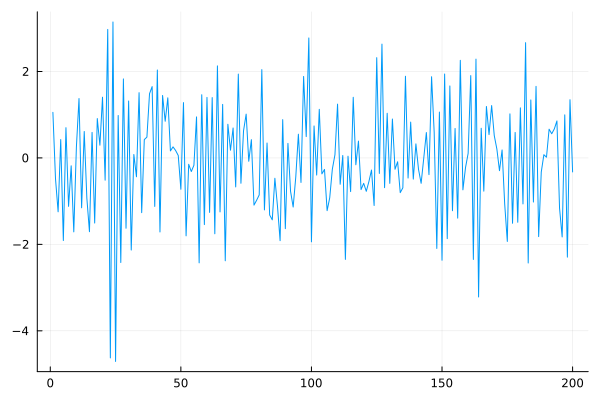

In [3]:
Random.seed!(321)

data = [0.0,0.0]

for t in 1:200
    push!(data,-0.3*data[end]+0.4*data[end-1]+randn())
end

data = data[3:end]

plot(data,legend=:none)

In [4]:
m = ARMA(2,0)
ps,f = Flux.destructure(m)

([0.25, 0.25, 0.0, 1.0], Restructure(ARMA, ..., 4))

In [ ]:
for i in 1:500    
    grads = ForwardDiff.gradient(x -> -llikelihood(f(vcat(x)),data), ps)
    hess = ForwardDiff.hessian(x -> -llikelihood(f(x),data), ps)
    
    ps .-= 0.01 .* inv(hess.+Diagonal(ones(length(grads)).*1e-5))*grads
    if i%50==0
        println(-llikelihood(f(ps),data))
    end
end

In [ ]:
optimized_model = f(ps)

In [ ]:
optimized_model.Φ #reasonably close to [-0.3, 0.4]